#### TFM Raquel Lozano Gómez - Máster en Economía (Universidad de Vigo)

## Simulación

In [1]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from itertools import combinations
from itertools import permutations
from collections import defaultdict
from math import factorial
from scipy.optimize import minimize

Para ilustrar cómo una transformación cardinal deriva en alteraciones del valor de Shapley aún manteniendo constantes las preferencias ordinales, se simula el cálculo del equilibrio de Nash y del valor de Shapley bajo distintos supuestos de utilidad. 

### Ejemplo 1. Valor de Shapley vs. Equilibrio de Nash

#### Valor de Shapley

Para empezar, se define el conjunto finito de jugadores en $ N = \{1, \dots, n\}$ y se generan todas las posibles coaliciones.

In [11]:
# Número de jugadores
n = int(input("Número de jugadores: "))
players = sorted([input(f"Nombre del jugador {i+1}: ").strip() for i in range(n)])
#player1, player2, player3 = players

Número de jugadores:  2
Nombre del jugador 1:  1
Nombre del jugador 2:  2


In [12]:
# Coaliciones posibles
def all_coalitions(players):
    return [frozenset(c) for r in range(len(players) + 1) 
            for c in combinations(players, r)]
coalitions = all_coalitions(players)

Dada una función de utilidad característica $v: 2^N \rightarrow \mathbb{R}$, se introducen manualmente los valores de utilidad $v(S)$ correspondientes a cada coalición, distinguiendo entre distintas funciones de utilidad sobre las que se aplican transformaciones monótonas. A posteriori, se calcula el valor de Shapley para cada jugador definido según la ecuación característica $$\phi_j(v) = \sum_{S \subseteq N \,:\, j \in S} \frac{(|S| - 1)! \cdot (n - |S|)!}{n!} \left[ v(S) - v(S - \{j\}) \right],$$ iterando sobre todos los subconjuntos posibles.

In [13]:
# Funciones de utilidad
utility_functions = {}
num_functions = int(input("\nNúmero de funciones de utilidad: "))

for k in range(num_functions):
    fname = input(f"\nNombre para la función de utilidad #{k+1}: ").strip()
    print(f"\nValores para la función de utilidad '{fname}'")
    v = {}
    for coalition in coalitions:
        sorted_names = ",".join(sorted(coalition))
        label = f"{{{sorted_names}}}"
        val_str = input(f"Valor de v({label}): ")
        val = float(val_str) if val_str else 0.0
        v[coalition] = val
    utility_functions[fname] = v


Número de funciones de utilidad:  2

Nombre para la función de utilidad #1:  og



Valores para la función de utilidad 'og'


Valor de v({}):  0
Valor de v({1}):  10
Valor de v({2}):  20
Valor de v({1,2}):  35

Nombre para la función de utilidad #2:  alt



Valores para la función de utilidad 'alt'


Valor de v({}):  0
Valor de v({1}):  20
Valor de v({2}):  40
Valor de v({1,2}):  70


In [14]:
# Valor de Shapley 
def shapley_value(players, v):
    n = len(players)
    phi = dict.fromkeys(players, 0.0)
    for i in players:
        for S in coalitions:
            if i not in S:
                S_with_i = S | {i}
                s = len(S)
                coef = factorial(s) * factorial(n - s - 1) / factorial(n)
                phi[i] += coef * (v[S_with_i] - v.get(S, 0))
    return phi

Finalmente, se visualizan los resultados obtenidos para cada una de las funciones de utilidad consideradas.

In [15]:
# Resultados 
for fname, v in utility_functions.items():
    print(f"\nValor de Shapley para la función '{fname}'")
    shapley = shapley_value(players, v)
    for player, phi in shapley.items():
        print(f"{player}: {round(phi, 3)}")


Valor de Shapley para la función 'og'
1: 12.5
2: 22.5

Valor de Shapley para la función 'alt'
1: 25.0
2: 45.0


#### Equilibrio de Nash

A partir de los valores del juego cooperativo contenidos en la función característica $v(S)$ se
pueden representar dos juegos en forma normal para calcular los equilibrios de Nash en estrategias
puras.

In [8]:
# Equilibrio de Nash
def find_nash_eq(A, B):
    num_rows, num_cols = A.shape
    equilibrios = []

    for i in range(num_rows):
        for j in range(num_cols):
            a_ij = A[i, j]
            b_ij = B[i, j]
            # Verifica si A[i,j] es el mejor de su fila para jugador 1
            if a_ij >= A[i, :].max():
                # Verifica si B[i,j] es el mejor de su columna para jugador 2
                if b_ij >= B[:, j].max():
                    # Filtra perfiles donde ambos pagos son 0
                    if a_ij > 0 or b_ij > 0:
                        equilibrios.append((i, j))

    return equilibrios

Dentro del conjunto de funciones de utilidad disponibles, se selecciona una de ellas para así
construir la matriz de pagos del juego.

In [9]:
# Selección función de utilidad a emplear
print("\nFunciones de utilidad disponibles:")
for name in utility_functions:
    print(f" - {name}")

selected_fname = input("\nFunción de utilidad a emplear: ").strip()
while selected_fname not in utility_functions:
    selected_fname = input("Nombre no válido. Introduce uno de los anteriores: ").strip()
v = utility_functions[selected_fname]


Funciones de utilidad disponibles:
 - original
 - alternativa



Función de utilidad a emplear:  original


En base a dicha función $v(S)$, se construyen dos matrices A y B, que representan los pagos
del jugador 1 y del jugador 2, respectivamente. Cada entrada de estas matrices se interpreta en
función de la coalición resultante de las acciones individuales:

In [9]:
# Pagos para el jugador 1
a11 = v[frozenset({'i', 'j'})] 
a12 = v[frozenset({'i'})]      
a21 = v[frozenset()]       
a22 = v[frozenset()]            

# Pagos para el jugador 2 
b11 = v[frozenset({'i', 'j'})]
b12 = v[frozenset()]
b21 = v[frozenset({'j'})]
b22 = v[frozenset()]

In [10]:
# Matriz de pagos
A = np.array([[a11, a12],
              [a21, a22]])

B = np.array([[b11, b12],
              [b21, b22]])

De la función computacional que explora todas las combinaciones posibles de estrategias puras,
se calcula el equilibrio de Nash en estrategias puras.

In [11]:
# Resultado
equilibrios_puros = find_nash_eq(A, B)
print("Equilibrios de Nash en estrategias puras:", equilibrios_puros)
for (i, j) in equilibrios_puros:
    print("Pagos en el equilibrio:", (A[i, j], B[i, j]))

Equilibrios de Nash en estrategias puras: [(0, 0)]
Pagos en el equilibrio: (40.0, 40.0)


Por último, se representa el juego en el que cada celda contiene los pagos individuales de ambos
jugadores para la combinación de estrategias correspondiente.

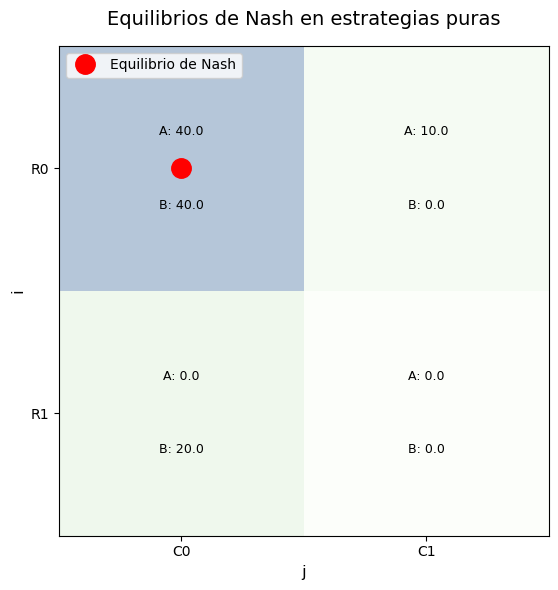

In [12]:
# Gráfica
fig, ax = plt.subplots(figsize=(6, 6))
combined = A + B
im = ax.imshow(combined, cmap="GnBu", alpha=0.3)

# Pagos (A[i,j], B[i,j]) dentro de cada celda
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        ax.text(j, i - 0.15, f"A: {A[i, j]}", ha='center', va='center', fontsize=9, color='black')
        ax.text(j, i + 0.15, f"B: {B[i, j]}", ha='center', va='center', fontsize=9, color='black')

# Equilibrio
for idx, (i, j) in enumerate(equilibrios_puros):
    ax.plot(j, i, 'ro', markersize=14, label='Equilibrio de Nash' if idx == 0 else "")

ax.set_xticks(np.arange(A.shape[1]))
ax.set_yticks(np.arange(A.shape[0]))
ax.set_xticklabels([f"C{j}" for j in range(A.shape[1])])
ax.set_yticklabels([f"R{i}" for i in range(A.shape[0])])
ax.set_title("Equilibrios de Nash en estrategias puras", fontsize=14, pad=15)
ax.grid(False)
ax.legend(loc='upper left', fontsize=10)
ax.set_xlabel(player2, fontsize=12)
ax.set_ylabel(player1, fontsize=12)

plt.tight_layout()
plt.show()

La nueva distribución de pagos entre $\phi(v_1)$ y $\phi(v_2)$, pese a que las preferencias ordinales sean idénticas, confirma que el valor de Shapley no es invariante ante transformaciones monótonas de utilidad.

### Ejemplo 2. Valor de Shapley - Asignación Valor

Supóngase una economía $E$ con dos jugadores $j \in \{1, 2\}$ en la cual las dotaciones iniciales de cada individuo son $w_1 = (1, 10)$, $w_2 = (4, 5)$. Sus utilidades vienen definidas por las funciones $u_1(x, y) = xy$ y $u_2(x, y) = \sqrt{2x + y}$.

Para empezar, se definen tanto las dotaciones como las funciones de utilidad para el conjunto finito de jugadores $N = \{1, 2\}$.

In [17]:
# Dotaciones iniciales
endowments = {
    1: (1, 10),
    2: (4, 5)
}

In [18]:
# Funciones de utilidad
def u1(x, y):
    return x * y

def u2(x, y):
    return np.sqrt(2 * x + y)

utilities = {1: u1, 2: u2}

A posteriori, se generan todas las posibles coaliciones $S \subseteq N$, y se calcula el valor asociado $v(S)$ a cada una de las funciones de utilidad. Por un lado, se evalúan las dotaciones iniciales en cada una de las funciones de utilidad para las coaliciones unipersonales $v(\{j\})$.

In [19]:
# Cálculo v({j})
def individual_value(agent):
    x, y = endowments[agent]
    return utilities[agent](x, y)

Por otro lado, $v(\{N\})$ = $v(\{1,2\})$ se obtiene resolviendo numéricamente el problema de maximización de la asignación de valor:
$v(S) = \max \left\{ \sum_{j \in S} u_j(x_j) \;\middle|\; \sum_{j \in S} x_j \leq \sum_{j \in S} \omega_j \right\}$

In [20]:
# Cálculo v({1,2}) mediante un problema de maximización
def coalition_value(coalition):
    total_x = sum(endowments[i][0] for i in coalition)
    total_y = sum(endowments[i][1] for i in coalition)
    n = len(coalition)

    def objective(allocation):
        ut = 0
        for i, agent in enumerate(coalition):
            x, y = allocation[2*i], allocation[2*i + 1]
            if x <= 0 or y <= 0:
                return np.inf
            ut -= utilities[agent](x, y)
        return ut

    bounds = [(1e-6, total_x if i % 2 == 0 else total_y) for i in range(2 * n)]
    constraints = [
        {'type': 'eq', 'fun': lambda a: total_x - sum(a[::2])},
        {'type': 'eq', 'fun': lambda a: total_y - sum(a[1::2])}
    ]
    x0 = [total_x / n, total_y / n] * n

    result = minimize(objective, x0, bounds=bounds, constraints=constraints)
    return -result.fun if result.success else np.nan

In [21]:
# Cálculo valores de todas las coaliciones
coalitions = {}
N = {1, 2}

for r in range(1, len(N) + 1):
    for coalition in combinations(N, r):
        if len(coalition) == 1:
            coalitions[coalition] = individual_value(coalition[0])
        else:
            coalitions[coalition] = coalition_value(coalition)

coalitions[(1, 2)] = coalition_value((1, 2))

print("Valores de las coaliciones:")
for k, v in coalitions.items():
    print(f"v{list(k)} = {v:.3f}")

Valores de las coaliciones:
v[1] = 10.000
v[2] = 3.606
v[1, 2] = 75.050


Una vez obtenidos los valores de utilidad para todas las coaliciones, se calculan las contribuciones marginales por permutación.

In [22]:
# Cálculo contribuciones marginales por permutación
def shapley_from_permutations(N, coalitions):
    contribs = {i: [] for i in N}
    for perm in permutations(N):
        S = ()
        for i in perm:
            prev_value = coalitions.get(tuple(sorted(S)), 0)
            S = tuple(sorted(S + (i,)))
            new_value = coalitions.get(S, 0)
            marginal = new_value - prev_value
            contribs[i].append(marginal)
    return {i: np.mean(contribs[i]) for i in N}, contribs

shapley_vals, marginal_table = shapley_from_permutations(N, coalitions)
print("\nTabla de contribuciones marginales por permutación:")
for i in N:
    print(f"Jugador {i}: {marginal_table[i]}")


Tabla de contribuciones marginales por permutación:
Jugador 1: [10, 71.44444360232609]
Jugador 2: [65.04999487779008, 3.605551275463989]


Por último, se calcula el valor de Shapley para cada jugador, iterando sobre todos los subconjuntos posibles. 

In [23]:
# Cálculo del valor de Shapley
def shapley_value(i, N, coalitions):
    n = len(N)
    phi = 0
    for r in range(len(N)):
        for S in combinations(N - {i}, r):
            S = set(S)
            S_with_i = tuple(sorted(S | {i}))
            S = tuple(sorted(S))
            coef = factorial(len(S)) * factorial(n - len(S) - 1) / factorial(n)
            marginal = coalitions.get(S_with_i, 0) - coalitions.get(S, 0)
            phi += coef * marginal
    return phi

print("\nValores de Shapley:")
for i in N:
    phi_i = shapley_value(i, N, coalitions)
    print(f"Jugador {i}: {phi_i:.3f}")


Valores de Shapley:
Jugador 1: 40.722
Jugador 2: 34.328


Además, las preferencias de los jugadores están representadas por las funciones de utilidad $v_1(x,y) = lnx + lny$ y $v_2(x,y) = \sqrt{2x + y}$.

De manera análoga, se especifican las funciones de utilidad con su tranformación monótona creciente.

In [3]:
# Funciones de utilidad
def v1(x, y):
    return np.log(x) + np.log(y)

def v2(x, y):
    return np.sqrt(2 * x + y)

utilities = {1: v1, 2: v2}

In [25]:
# Cálculo v({j})
def individual_value(agent):
    x, y = endowments[agent]
    return utilities[agent](x, y)

In [26]:
# Cálculo v({1,2}) mediante un problema de maximización
def coalition_value(coalition):
    total_x = sum(endowments[i][0] for i in coalition)
    total_y = sum(endowments[i][1] for i in coalition)
    n = len(coalition)

    def objective(alloc):
        ut = 0
        for i, agent in enumerate(coalition):
            x, y = alloc[2*i], alloc[2*i + 1]
            if x <= 0 or y <= 0:
                return np.inf
            ut -= utilities[agent](x, y)
        return ut

    bounds = [(1e-6, total_x if i % 2 == 0 else total_y) for i in range(2 * n)]
    constraints = [
        {'type': 'eq', 'fun': lambda a: total_x - sum(a[::2])},
        {'type': 'eq', 'fun': lambda a: total_y - sum(a[1::2])}
    ]
    x0 = [total_x / n, total_y / n] * n

    result = minimize(objective, x0, bounds=bounds, constraints=constraints)
    return -result.fun if result.success else np.nan

In [27]:
# Cálculo valores de todas las coaliciones
coalitions = {}
N = {1, 2}

for r in range(1, len(N) + 1):
    for coalition in combinations(N, r):
        if len(coalition) == 1:
            coalitions[coalition] = individual_value(coalition[0])
        else:
            coalitions[coalition] = coalition_value(coalition)

coalitions[(1, 2)] = coalition_value((1, 2))

print("Valores de las coaliciones:")
for k, v in coalitions.items():
    print(f"v{list(k)} = {v:.3f}")

Valores de las coaliciones:
v[1] = 2.303
v[2] = 3.606
v[1, 2] = 6.517


In [28]:
# Cálculo contribuciones marginales por permutación
def shapley_from_permutations(N, coalitions):
    contribs = {i: [] for i in N}
    for perm in permutations(N):
        S = ()
        for i in perm:
            prev_value = coalitions.get(tuple(sorted(S)), 0)
            S = tuple(sorted(S + (i,)))
            new_value = coalitions.get(S, 0)
            marginal = new_value - prev_value
            contribs[i].append(marginal)
    return {i: np.mean(contribs[i]) for i in N}, contribs

shapley_vals, marginal_table = shapley_from_permutations(N, coalitions)
print("\nTabla de contribuciones marginales por permutación:")
for i in N:
    print(f"Jugador {i}: {marginal_table[i]}")


Tabla de contribuciones marginales por permutación:
Jugador 1: [2.302585092994046, 2.9115658902417194]
Jugador 2: [4.214532072711663, 3.605551275463989]


In [29]:
# Cálculo del valor de Shapley
def shapley_value(i, N, coalitions):
    n = len(N)
    phi = 0
    for r in range(len(N)):
        for S in combinations(N - {i}, r):
            S = set(S)
            S_with_i = tuple(sorted(S | {i}))
            S = tuple(sorted(S))
            coef = factorial(len(S)) * factorial(n - len(S) - 1) / factorial(n)
            marginal = coalitions.get(S_with_i, 0) - coalitions.get(S, 0)
            phi += coef * marginal
    return phi

print("\nValores de Shapley:")
for i in N:
    phi_i = shapley_value(i, N, coalitions)
    print(f"Jugador {i}: {phi_i:.3f}")


Valores de Shapley:
Jugador 1: 2.607
Jugador 2: 3.910
